<h3> HANDY PYTHON PACKAGES </h3>

In [2]:
import requests
import json
from random import randint
import math
import pandas as pd
from IPython.display import display, HTML, JSON
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import datetime
import shapely
from shapely.geometry import box
from matplotlib.patches import Polygon
from matplotlib import colors
%matplotlib inline

<H3> AUXILIARY FUNCTIONS </H3>

In [3]:
def get_url_addon(params):
    """
    Concatenates the params and their values in an unique string to later be attached to the generic API ENDPOINTS
    This function expects as argument and object with as many keys and values as conditions 
    the user want the data-sources to meet:
        params = {
            'initial_datetime':[],
            'end_datetime':[],
            'standard_variable':[],
            'bbox': [min. lat., max. lat., min. lon., max. lon]
            'elevation_range': [min. elevation, max. elevation. ],
            'processing_level':[],
            'feature_type':[],
            'resample_rule':[],
            'resample_how':[],
            'max_qc_value':[]
        }

    """    
    url_addon = ''
    for key in params:
        if key == 'bbox' or key == 'elevation_range':
            url_addon = url_addon+'&'+key+'='+','.join(params[key])
            continue
        for item in params[key]:
            url_addon = url_addon+'&'+key+'='+item
    return '?'+url_addon[1:len(url_addon)] 

In [4]:
def render_data_overview(response):
    cols = ['proc level','type','coordinates','standard_name','parameter']; numb = 0; rows = []; values = []
    for key in response.keys():
        for feature in response[key]['features']:
            for variable in feature['variables']:
                for param in feature['variables'][variable].keys():
                    #data = ','.join(str(e) for e in feature['variables'][variable][param]['data'][:10]) 
                    #units = feature['variables'][variable][param]['units']
                    #precision = feature['variables'][variable][param]['precision']
                    rows.append(numb)    
                    values.append([key,feature['feature_type'],','.join(feature['coordinates'].keys()),variable,param])
                    numb = numb +1
    return [values,rows,cols]

In [5]:
def get_parameter(response, parameter):
    for key in response.keys():
        for feature in response[key]['features']:
            for variable in feature['variables']:
                for param in feature['variables'][variable].keys():
                    if param == parameter:
                        data = feature['variables'][variable][param]['data']
                        #units = feature['variables'][variable][param]['units']
                        #precision = feature['variables'][variable][param]['precision']
                        coordinates = ','.join(feature['coordinates'].keys())
                        return [data, coordinates]

In [6]:
def get_coordinate(response, coordinate):
    for key in response.keys():
        for feature in response[key]['features']:
            for coordinates in feature['coordinates'].keys():
                if coordinates == coordinate:
                    data = feature['coordinates'][coordinate]['data']
                    #units = feature['coordinates'][coordinate]['units']                      
                    return [data] #, units

<H3> PREREQUISITES</H3>

In [7]:
api_key = '' #write you SOCIB api_key
api_url = 'http://api.socib.es'
headers = {
    'accept': 'application/vnd.socib+json',
    'api_key': api_key,
}

<H3>HOW DO I ASK FOR A DATA-SOURCE'S DATA'?</H3>

Once you know a data-souce id, SOCIB API provides an ENDPOINT for retrieveing a given data-source's data. This is the /data-sources/{id}/data ENDPOINT. Let's choose randmomly a data-source and explore such endpoint with it.

In [34]:
end_point = '/data-sources/'
request = requests.get('%s%s' % (api_url, end_point), headers=headers)
response = json.loads(request.text)

random = randint(0,response['count']-1) #random deployment
frac, whole = math.modf(float(random)/8) #there is a pagination of 8 deployments (position 0, 1, 2, 3, 4, 5, 6, 7)
page = int(whole) + 1
position = int(8 - ((page*8) - random))
print('i.e Deployment number %s is on page %s at position %s'%(random,page,position))

i.e Deployment number 405 is on page 51 at position 5


In [9]:
#requesting the page where the deployment is
end_point = '/data-sources/'
page_request = requests.get('%s%s?%s' % (api_url, end_point, 'page='+str(page)), headers=headers)
page_response = json.loads(page_request.text)
print('Requested url: '+'%s%s?%s' % (api_url, end_point, 'page='+str(page)))

#accessing the targeted deployment:
targeted_deployment = page_response['results'][position]

#info of the targeted deployment  into table
df = pd.DataFrame(targeted_deployment.values(), index=targeted_deployment.keys(), columns=['deployment '+targeted_deployment['id']])
df.style

Requested url: http://api.socib.es/data-sources/?page=51


From the above answer we can either rely on the services available at SOCIB for accessing, viewing and downloading the netCDFS storing the data associated to the data-source (deployment) or rely on the API to skip having to interact with such format.  

If you recognize the netCDF format and already know how to deal with it, go ahead and explore hte associated netCDF files using the available services:

In [10]:
print('Available services for the '+ str(len(targeted_deployment['entries']))+' netCDFs associated to '+targeted_deployment['id']+' data-source (deployment) :')
entries = targeted_deployment['entries']
for netCDF in entries:
    values = []
    indexes = []
    for key in netCDF.keys():
        indexes.append(key)
        if key == 'services' or key == 'viewers':
            val = ''
            for item in netCDF[key].keys():
                val = val+'<a href="'+netCDF[key][item]['url']+'" target="_blank">'+netCDF[key][item]['url']+'</a> ('+item+')<br>'
            values.append(val)
        else:
            values.append(netCDF[key])

    df = pd.DataFrame(values, index=indexes, columns=[netCDF['services']['http_file']['url'].split('/')[len(netCDF['services']['http_file']['url'].split('/'))-1]])
    display(df.style)

Available services for the 2 netCDFs associated to e93fcb63f3 data-source (deployment) :


If a netCDF is an alien format to you, welcome to one of SOCIB API advantages: you do not have to even care about how the data is physically stored for retrieveing it. SOCIB API provides the /DATA-SOURCE/{ID}/DATA ENDPOINT for retrieveing a given data-source's data and even make a certain processing on-the-fly. Let's dig a bit more into it.

<H3>EXPLORING THE /DATA-SOURCES/{ID}/DATA ENDPOINT </H3>

Just by attaching a given data-source's ID (deployment's id) to the generic /data-sources/ ENDPOINT, we obtain a detailed view of this data-source. For example, taking the id of the above deployment:

In [11]:
deployment_id = targeted_deployment['id']

#requesting the deployment by id
end_point = '/data-sources/'+deployment_id
request = requests.get('%s%s' % (api_url, end_point), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s' % (api_url, end_point))

#info of the targeted deploymentinto table
df = pd.DataFrame(response.values(), index=response.keys(), columns=['deployment '+response['id']])
df.style

Requested url: http://api.socib.es/data-sources/e93fcb63f3


Here nothing new, indeed, we already obtained the above information when randomly looking for a data-source (deployment). The scenario changes though, when you attach to this same url the /data-sources/{id}/data/ ENDPOINT. Let's have a quick view of the information returned by such ENDPOINT:

In [12]:
deployment_id = targeted_deployment['id']
#requesting the deployment's data by id
end_point = '/data-sources/'+deployment_id+'/data/'
request = requests.get('%s%s' % (api_url, end_point), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s' % (api_url, end_point))

#info of the targeted deploymentinto table
[values, rows, cols] = render_data_overview(response)
df = pd.DataFrame(values, index=rows, columns=cols)
display(df.style)

Requested url: http://api.socib.es/data-sources/e93fcb63f3/data/


From this point, to access any of the parameters above, you can either explore the response object struture or rely on the auxiliary functions get_parameter (get_coordinate if it is coordinate). Let's see it next. 

In [25]:
#variables
temp = get_parameter(response,'WTEM')[0]
temp = np.array(temp,dtype=float)

#coordinates
lon = get_coordinate(response,'longitude')[0]
lat = get_coordinate(response,'latitude')[0]
lat = np.array(lat,dtype=float)
lon = np.array(lon,dtype=float)

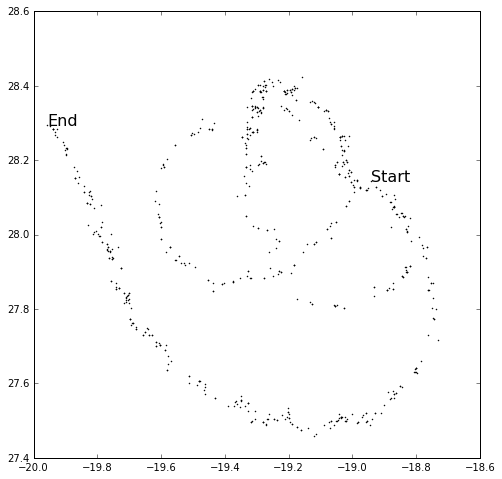

In [26]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.plot(lon, lat, 'ko', ms=1)
plt.text(lon[0], lat[0], 'Start', fontsize=16)
plt.text(lon[-1], lat[-1], 'End', fontsize=16)
plt.show()

In [27]:
lonmin, lonmax = ax.get_xlim()
latmin, latmax = ax.get_ylim()
cmap = plt.cm.Spectral_r
norm = colors.Normalize(vmin=min(temp), vmax=max(temp))

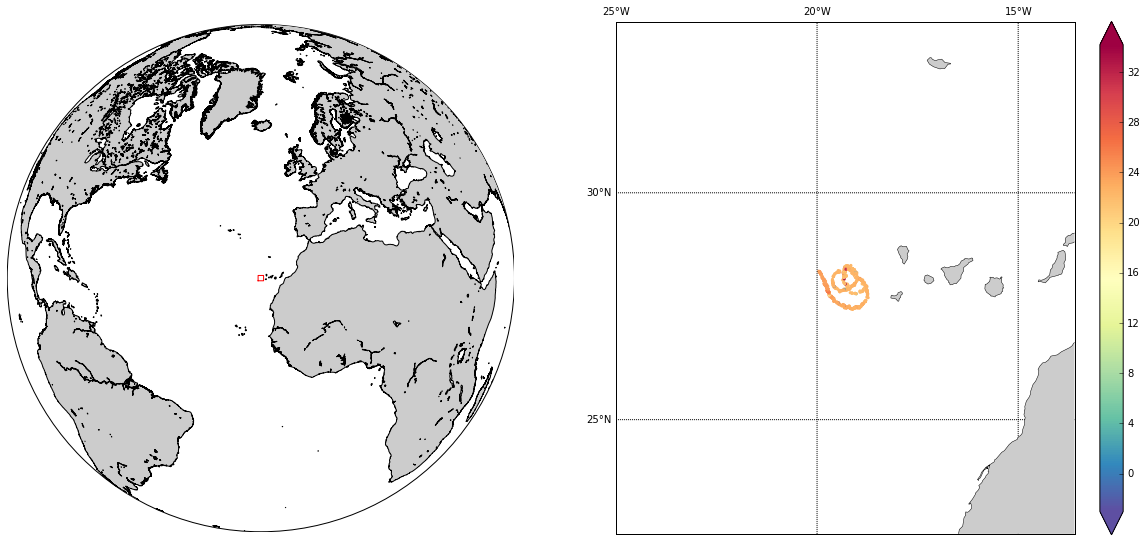

In [29]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(122)
m = Basemap(projection='merc', llcrnrlat=latmin-5, urcrnrlat=latmax+5,
            llcrnrlon=lonmin-5, urcrnrlon=lonmax+5, lat_ts=20, resolution='i')
lon2, lat2 = m(lon, lat)
m.scatter(lon2, lat2, s=10, c=temp, edgecolor='None', cmap=cmap, norm=norm)
m.drawcoastlines(linewidth=0.5, zorder=3)
m.fillcontinents(zorder=2)
m.drawparallels(np.arange(-90.,91.,5.), labels=[1,0,0,0], zorder=1)
m.drawmeridians(np.arange(-180.,181.,5.), labels=[0,0,1,0], zorder=1)
plt.colorbar(fraction=0.046, extend='both', cmap=cmap, norm=norm)

ax = fig.add_subplot(121)
bounding_box = shapely.geometry.box(lonmin, latmin, lonmax, latmax)
x = bounding_box.centroid.x
y = bounding_box.centroid.y
map = Basemap(projection='ortho',lat_0=y, lon_0=x,resolution='i')
map.drawmapboundary()
map.fillcontinents()
map.drawcoastlines()
xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
ys = [latmin,latmin,latmax,latmax,latmin]
map.plot(xs, ys,latlon = True, color='red')
plt.show()